# Sistemes de Recomanació

En aquest primer lliurament es programarà un **sistema de recomanació**, que posarà en correspondència un *usuari* amb *ítems* en funció de les seves preferències i interessos. 
En aquesta ocasió, implementareu un sistema de recomanació que assisteixi en una compra de supermercat.

## Abans de començar


**\+ Durant la pràctica, solament es podran fer servir les següents llibreries**:

`Pandas, Numpy, Itertools`

*Nota: A més de les que ja es troben presents en la 1a cel·la i funcions natives de Python*

**\+ No es poden modificar les definicions de les funcions donades, ni canviar els noms de les variables i paràmetres ja donats**

Això no implica però que els hàgiu de fer servir. És a dir, que la funció tingui un paràmetre anomenat `df` no implica que l'hàgiu de fer servir, si no ho trobeu convenient.

**\+ En les funcions, s'especifica que serà i de quin tipus cada un dels paràmetres, cal respectar-ho**

Per exemple (ho posarà en el pydoc de la funció), `df` sempre serà indicatiu del `Pandas.DataFrame` de les dades. Durant la correcció, els paràmetres (i específicament `df`) no contindran les mateixes dades que en aquest notebook, si bé si seran del mateix tipus! Per tant, no us refieu de què tinguin, per exemple, el mateix nombre de files.

# Preparar les dades

### **En aquesta cel·la no féu cap modificació**

Descomprimeix els zips a la carpeta "data" automàticament. 

Descarregueu el zip amb les dades del campus i guardeu-lo dins de la carpeta del projecte. No pugeu els arxius de dades al campus, només el codi i les prediccions.

In [4]:
import zipfile
import pickle
from os.path import join, dirname

def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('data')
    zip_ref.close()
    
unzip('dades_p2.zip')

# Les dades

En aquest notebook farem servir dades reals corresponents a compres, concretament les utilitzades en el Kaggle Instacart Market Basket Analysis:
https://www.kaggle.com/c/instacart-market-basket-analysis


* **Order Products**: És el de major interès, conté la relació de productes comprats (`product_id`) per a cada conjunt de compra diferent (`order_id`). A aquests conjunts de compres ens hi referirem com a `ordres`, seguint la nomenclatura de les dades. A més, tot i que no ho farem servir, podríem arribar a saber en quin ordre s'han comprat els productes (`add_to_cart_order`) i inclús si ja s'havia comprat en alguna ordre anterior (`reordered`).

* **Orders**: Aquest dataset ens permet relacionar una compra en concret (`order_id`) amb l'usuari que l'ha feta (`user_id`)

* **Products**: Donat un `product_id` ens permet obtenir-ne més informació, com ara el nom (`product_name`), la secció en la qual es troba (`aisle_id`) o al departament al qual pertany (`department_id`). Aquests dos últims es complementen amb els conjunts **Aisles** i **Departments**.


# Data loading

### **En aquestes cel·les no feu cap modificació**

Carrega les dades en un DataFrame Pandas.

In [5]:
import pandas as pd

df_order_prods = pd.read_csv(join('data', 'order_products__train.csv'))
df_orders = pd.read_csv(join('data', 'orders.csv'))[['order_id', 'user_id']]
df_prods = pd.read_csv(join('data', 'products.csv'))[['product_id', 'aisle_id']]

# Implementació

Recordeu, seguiu els pydoc i compliu amb el que diuen!

El primer que haurem de fer és construir una matriu que ens serveixi, d'alguna forma, com a indicatiu de preferències de cada persona. Per tal efecte, construirem una matriu $m\times n$, de $m$ usuaris per $n$ items, on cada entrada $i,j$ serà el nombre de vegades que la persona $i$ ha comprat l'item $j$.

<img src="img/Mat.png">

Per saber de quin usuari és cada `order_id`, haureu de creuar el dataset `order_products` amb el `orders`. Una sola persona/usuari tindrà més d'una ordre, mireu quants cops ha comprat els mateixos productes.

A més, les dades es componen de molts `product_id` diferents, hi ha massa diversitat entre usuaris. Per tant, per poder recomanar el que farem serà agregar les dades, en lloc de treballar per `product_id` ho farem per `aisle_id`, és a dir "la secció" del súper on es troba.

Al llarg de la pràctica es parlarà de producte i/o item, perquè és la terminologia estàndard de recomanadors, però sempre serà en referència a `aisle_id` per aquesta pràctica!

In [6]:
def merge_information(df_order_prods, df_orders, df_prods):
    """
    Retorna el dataframe resultant de:
        1. Creuar els datasets 'order_products' amb 'orders'.
        2. Creuar el dataframe anterior amb 'products'.
        Per creuar dos dataframes podeu utilitzar la funció pandas.DataFrame.merge

    :param df_order_prods: DataFrame 'order_products'
    :param df_orders: DataFrame 'orders'
    :param df_prods: DataFrame 'products'
    :return: DataFrame descrit prèviament   
    """
    
    tmp = pd.merge(df_order_prods, df_orders, how='inner', on='order_id')
    merged = pd.merge(tmp, df_prods, how='inner', on='product_id')
    return merged

In [7]:
df_merged = merge_information(df_order_prods, df_orders, df_prods)

In [8]:
def build_counts_table(df):
    """
    Retorna un dataframe on les columnes són els `aisle_id`, les files `user_id` i els valors
    el nombre de vegades que un usuari ha comprat un producte d'un `aisle_id`
    
    :param df: DataFrame original després de creuar-lo
    :return: DataFrame descrit adalt
    """
    return pd.crosstab(df['user_id'], df['aisle_id'])

def get_count(df, user_id, aisle_id):
    """
    Retorna el nombre de vegades que un usuari ha comprat en un `aisle_id`
    
    :param df: DataFrame retornat per `build_counts_table`
    :param user_id: ID de l'usuari
    :param aisle_id: ID de la secció
    :return: Enter amb el nombre de vegades que ha comprat
    """
    return df.loc[[user_id],[aisle_id]]

In [9]:
df_counts = build_counts_table(df_merged)
count = get_count(df_counts, 14, 5)
print(count)

aisle_id  5
user_id    
14        2


In [29]:
import scipy.sparse
df_csr = scipy.sparse.csr_matrix(df_counts.values.astype(np.float32))

[ 2611  3592 11057  7880  2711  1725  1500  1397  8821   427  1090  1513
  3673  4167   890 12710  9942   721  9375  2681 31199  1169  6178 72178
  2383  7331  1127   906  2760  3204 17500  9828   542  3157  4999  9982
 15867 10780  1071  1177  1615  3659  4663   517  8622   795  1747  2587
  5384  5799  4821  8232 11429 10203   497   969  3433  1499  9670  1549
  8077   905  5585  3523  1421  5792 13434   615 11514  1121  1454  8333
   678  3600  3835   595 12689 15670  6428   800 10086   302 59172 29358
  2448 19348   831 10533  4113   860 22373  5144  8895  7083  2935 14248
   953 12280  3525  6933   870   301   462  7378  3996 11344 23182 11559
   478  4370  1587 21488   249  4223 26943 16834 10528   495   891 33249
 12849  3054 50257   787  1407   869  1865  7843  7555  5800  9526   274
   850   406]


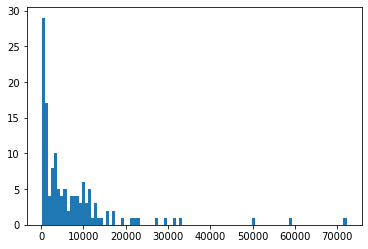

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Unes quantes dades estadístiques (aprofitem que estem fent Visió artificial i sabem què són els histogrames XD)

#Quants usuaris diferents compren un item?
counts = np.count_nonzero(df_counts.values, axis=0)
print(counts)
plt.hist(counts, bins=100)
plt.show() #
# Hi ha uns quants ítems que no els compra pràcticament ningú, tots aquests els podríem eliminar, gairebé mai els recomanarem


[10 14  7 ...  9 11  8]


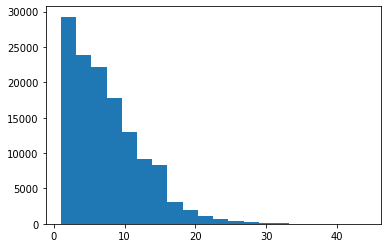

In [13]:
#Quants ítems diferents compra un usuari?
counts = np.count_nonzero(df_counts.values, axis=1)
print(counts)
plt.hist(counts, bins=20)
plt.show() #

In [22]:
#Podem eliminar els usuaris que només han comprat un nombre molt reduït d'ítems (una gran part)
# De la mateixa manera podem filtrar els ítems que els ha comprat molt poca gent
min_items = 5
min_users = 5

df_pre_reduced = df_counts[np.count_nonzero(df_counts.values, axis=1) > min_items]
df_pre_reduced  = df_pre_reduced.loc[:, np.count_nonzero(df_pre_reduced.values, axis=0) > min_users]

print(df_counts.shape, df_pre_reduced.shape)

(131209, 134) (78052, 134)


### Estadístiques de les dades

Donada la matriu que conté el nombre de vegades que un usuari ha comprat en una secció, calculeu:
- Els usuaris que més compren
- Les seccions amb més ventes

In [23]:
def top_active_users(counts, indexes, columns, n):
    """
    Exemple: Retorna els ids dels n usuaris que més compres han fet
    
    :param counts, indexes, columns: Tupla retornada per `build_counts_table`
    :param n: Quanitat d'usuaris
    :return: Llista, tupla o pd.Series de userID dels n usuaris
    """
    return counts.sum(axis=1).nlargest(n).index.values.tolist()

def top_sales_aisle(counts, indexes, columns, n):
    """
    Exemple: Retorna els ids de les n seccions amb més ventes
    
    :param counts, indexes, columns: Tupla retornada per `build_counts_table`
    :param n: Quanitat de seccions
    :return: Llista, tupla o pd.Series de aisle_id de les n seccions
    """
    return counts.sum().nlargest(n).index.values.tolist()

In [24]:
indexes = df_counts.index
columns = df_counts.columns

top_users = top_active_users(df_counts, indexes, columns, 5)
print('top_users: ', top_users)

top_sales = top_sales_aisle(df_counts, indexes, columns, 5)
print('top_sales: ', top_sales)

top_users:  [149753, 197541, 63458, 83993, 189951]
top_sales:  [83, 24, 123, 120, 21]


Tenim moltes dades en el nostre dataset, pel que és convenient que les reduïm una mica. Per començar a treballar recomanem que reduïu la mida a aproximadament 0.1 de l'original '(FRAC = 0.1)'.

In [35]:
FRAC = 0.2
df_reduced = df_counts.sample(frac=FRAC, random_state=1)

### Mesurament de similituds

El primer pas per poder recomanar és definir una funció de similitud entre vectors. Siguin $x, y$ vectors, de les següents propostes **implementa totes** i escull una pel teu recomanador:

* Distància euclidea (inversa): https://en.wikipedia.org/wiki/Euclidean_distance

$$sim(x, y) = \frac{1}{1 + \sqrt{\sum_i(x_i-y_i)^2}}\in [0, 1]$$

* Similitud cosinus: https://en.wikipedia.org/wiki/Cosine_similarity

$$sim(x, y) = \frac{x\cdot y}{||x||\hspace{0.1cm} ||y||} \in [-1,1]$$

* Correlació de Pearson: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

$${\displaystyle sim(x,y)={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}} \in [-1,1] \\ \text{On }\bar{x} = \frac{1}{n} \sum^n_i x_i\text{ la mitja (i anàlogament per y)}$$

* Jaccard:  https://en.wikipedia.org/wiki/Jaccard_index

$$sim(x,y) = \frac{|x \cap y|}{|x \cup y|}
$$

Aquesta funció mesura el nombre d'elements en comú dels dos vectors (numerador) i el nombre total d'elements diferents que hi ha entre els dos vectors. Per exemple:

$$
x = [1, \text{NaN}, 2, 3, \text{NaN}, 5] \\
y = [2, 1, \text{NaN}, \text{NaN}, \text{NaN}, \text{NaN}] \\
sim(x, y) = {{|x \cap y|}\over{|x \cup y|}} = {1 \over{5}} = 0.2
$$

Per implementar qualsevol d'aquestes únicament es permet l'ús de:

* `np.sum`
* `np.sqrt`
* `np.power`
* `np.dot`
* `np.linalg.norm`
* `np.mean`

I s'ha de fer **sense bucles**.

<hr>

Tingueu en compte que les similituds de Pearson i Cosinus consideren valors negatius per exemples oposats (a diferència de la distància euclideao Jacard). En cas de fer servir alguna d'aquestes dues, pensa (més endavant) en com afectaran els negatius en la recomanació.

En la similitud cosinus, vigileu amb casos on un usuari no ha comprat res, tindreu a ser una divisió entre 0.

En la correlació de Pearson, haureu de considerar casos on algun dels dos exemples tingui variància 0, ja que aleshores estareu fent una divisió entre 0. En tals casos, podeu retornar un valor per defecte o alguna de les altres mesures.

In [27]:
def similarity(x, y):
    """
    Definir quina de les similituds vols utilitzar  a l'execució.
    
    :param x: Primer vector
    :param y: Segon vector
    :return : Escalar (float) corresponent a la similitud
    """
    return cosine(x, y)

def euclid(x, y):
    """
    Retorna la distància euclidiana inversa de dos vectors n-dimensionals.
    
    :param x: Primer vector
    :param y: Segon vector
    :return : Escalar (float) corresponent a la distància euclidiana
    """
    return 1./(1+np.sqrt(np.sum(np.square(x-y))))

def cosine(x, y):
    """
    Retorna la similitud cosinus de dos vectors n-dimensionals.
    
    :param x: Primer vector
    :param y: Segon vector
    :return : Escalar (float) corresponent a la similitud cosinus
    """
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    dot = np.dot(x, y)
    if dot == 0:
        return 0
    return dot/(x_norm * y_norm)

def pearson(x, y):
    """
    Retorna la correlació de Pearson de dos vectors n-dimensionals.
    
    :param x: Primer vector
    :param y: Segon vector
    :return : Escalar (float) corresponent a la correlació de Pearson
    """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return cosine(x-x_mean, y-y_mean)

def jaccard(x, y):
    """
    Similitud entre x i y segons Jaccard
    
    :param x: Primer vector, com a np.array
    :param y: Segon vector, com a np.array
    :return : Escalar (float) corresponent a la similitud
    """
    intersection = x * y
    union = x + y
    if ~union.any():
        return 0
    return np.sum(intersection != 0)/np.sum(union != 0)

In [28]:
print(similarity(np.asarray([1, 1, 1]), np.asarray([1, 2, 3])))

0.9258200997725515


In [31]:
import scipy

#Implementació sparse de cosine matricial, s'ha d'acabar de veure si funciona
def sparse_cosine(x):
    numerator = x.dot(x.transpose())
    norm = scipy.sparse.linalg.norm(x, axis=1)
    denominator = norm.dot(norm.transpose())
    
    return numerator/denominator

def mat_cosine(x):
    numerator = np.dot(x, x.T)
    
    norm = np.linalg.norm(x, axis=1).astype(np.float32)
    denominator = norm.dot(norm.T)

    return np.divide(numerator,denominator,dtype=np.float32)

def mat_pearson(x):
    return mat_cosine(x - np.mean(x, axis=1)[:, np.newaxis])

In [32]:
u = mat_cosine(df_reduced)
print(u[0][0].dtype)

KeyboardInterrupt: 

In [ ]:
#Proves per fer funcionar la llibreria sparse


from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

df_csr = sparse.csr_matrix(df_reduced)

similarities = sparse_cosine(df_csr)
print(similarities)


### Matriu de similituds

Per fer recomanació col·laborativa existeixen dues opcions, fer un recomanador basat en usuaris o un en ítems:

* Recomanador basat en usuaris:
Considera la matriu $M\times N: \text{usuaris}\times\text{items}$, per recomanar t'hauràs de basar en les similituds entre els usuaris.

* Recomanador basat en items:
Considera la matriu $M\times N: \text{items}\times\text{usuaris}$, per recomanar t'hauràs de basar en les similituds entre els ítems.

Construeix una matriu de mida $M\times M$ on cada posició $i,j$ indica la distància entre l'element $i$ i el $j$. Així doncs, si estàs fent un recomanador basat en usuaris, `matriu[2, 3]` contindrà la similitud entre l'usuari 2 i el 3. En canvi, si l'estàs fent basat en ítems, `matriu[2, 3]` contindrà la similitud entre l'ítem 2 i el 3.

In [34]:
#from tqdm import tqdm_notebook

def similarity_matrix(similarity_function, df_counts):
    """
    Retorna una matriu de mida M x M on cada posició 
    indica la similitud entre usuaris (resp. ítems).
    
    :param similarity_function: Funció que calcularà la similitud 
        entre usuaris (resp. ítems)
    :param df_counts: Dataframe que conté el nombre de vegades que 
        un usuari ha comprat en un `aisle_id`
    :return : Matriu numpy de mida M x M amb les similituds.
    """
    if similarity_function == None:
        return mat_cosine(df_counts)
    else:
        n = df_counts.index.size #Nombre total d'uruaris
        sim_mat = np.empty((n, n), dtype=np.float32)
        
        for i in range(0, n):
            user_id = df_counts.index[i]
            for j in range(i+1, n):
                sim_mat[i,j] = similarity_function(df_counts.loc[user_id, :], df_counts.loc[df_counts.index[j], :])

        return sim_mat + (sim_mat.T) + np.identity(n)

Per cridar aquesta funció, el primer paràmetre pot ser:

* Alguna de les funcions que has programat abans (*euclid*, *cosine*, *pearson* o *jaccard*) (~@1h 30min treballant directament amb valors de numpy, ~@20h a partir de pandas pur)
* Opcionalment (no és obligatori fer-ho) podeu programar una funció que treballi específicament amb matrius (i no vectors). Si ho feu, cal gestionar-ho quan es rep `None`. No totes les funcions anteriorment anomenades són fàcils (ni intuïtives, ni hi caben en memòria) d'aplicar en forma matricial.  (@5s)

In [44]:
try:
    with open('similarities_petit.pkl', 'rb') as fp:
        similarities = pickle.load(fp)
except:
    similarities = similarity_matrix(None, df_reduced)
    with open('similarities_petit.pkl', 'wb') as fp:
        pickle.dump(similarities, fp, pickle.HIGHEST_PROTOCOL)

In [78]:
print(similarities[120,54])

NameError: name 'similarities' is not defined

### Generació de prediccions

Per fer recomanació col·laborativa, necessitem una funció que ens doni un valor de quant bona seria la recomanació. En el nostre cas i amb les nostres dades, volem una funció que ens indiqui quants cops compraria un usuari un producte donat.

* Si esteu fent un recomanador basat en usuaris, la puntuació per a un usuari $u$ i ítem $j$ és

$$pred(u, i) = \hat{r}_{u,i} = \frac{\sum_{p\neq u,r_{p,i}>0} sim(u, p)\cdot r_{p,i}}{\sum_{p\neq u,r_{p,i}>0} sim(u, p)}$$

On $r_{u,i}$ indica el nombre de vegades que l'usuari $u$ ha comprat l'l'ítem $i$.

És a dir, per cada usuari $p$ diferent de $u$ si aquest usuari ha comprat algun cop el producte $i$, la similitud entre $p$ i $u$ multiplicada pel nombre de vegades que l'usuari $p$ ha comprat l'l'ítem $i$ ($r_{p,i}$).

Ponderat per la suma de les similituds.

* Anàlogament, si està basat en ítem, la puntuació per a un usuari $u$ i ítem $j$ és

$$pred(u, i) = \hat{r}_{u,i} = \frac{\sum_{j\neq i,r_{u,j}>0} sim(i, j)\cdot r_{u,j}}{\sum_{j\neq i,r_{u,j}>0} sim(i, j)}$$

On $r_{u,i}$ indica el nombre de vegades que l'usuari $u$ ha comprat l'ítem $j$.

És a dir, per cada ítem $j$ diferent de $i$ si l'usuari al qui recomanem ha comprat l'ítem $j$, la similitud entre $i$ i $j$ multiplicada pel nombre de vegades que l'usuari al qui recomanem $u$ ha comprat l'ítem $j$ ($r_{u,j}$)

Ponderat per la suma de les similituds.

Fixeu-vos que, sigui quin sigui el cas, al final estem fent el producte vectorial entre dos vectors. Concretament, el producte vectorial entre les similituds i les compres. Fes una funció que calculi aquest resultat:

In [35]:
def calc_score(sims, counts):
    """
    * Si estàs implementant basat en usuaris:
        Donades les similituds i el nombre de vegades que l'usuari ha comprat
        cada ítem, retorna la predicció que indica quants cops compraria 
        l'usuari un nou ítem.
    
        :param sims: Similituds entre usuaris
        :param counts: Nombre de vegades que l'usuari ha comprat cada ítem,
        :return : Predicció (float) que indica quants cops compraria l'usuari un ítem.
        
        
    * Si estàs implementant basat en items:
        Donades les similituds i el nombre de vegades que l'item a recomanar ha
        estat comprat per cada usuari, retorna la predicció que indica quants cops
        compraria l'usuari un nou ítem.
    
        :param sims: Similituds entre items
        :param counts: Nombre de vegades que l'ítem ha estat comprat per cada usuari
        :return : Predicció (float) que indica quants cops compraria l'usuari un ítem.
    """
    return np.dot(sims, counts)/np.sum(sims)

$$pred(u, i) = \hat{r}_{u,i} = \bar{r_u} + \frac{\sum_{p\neq u,r_{p,i}>0} sim(u, p)\cdot (r_{p,i}-\bar{r_p})}{\sum_{p\neq u,r_{p,i}>0} sim(u, p)}$$

In [70]:
def calc_score_mean(sims, counts, means, user_id):
    """
    * Si estàs implementant basat en usuaris:
        Donades les similituds i el nombre de vegades que l'usuari ha comprat
        cada ítem, retorna la predicció que indica quants cops compraria 
        l'usuari un nou ítem.
    
        :param sims: Similituds entre usuaris
        :param counts: Nombre de vegades que l'usuari ha comprat cada ítem,
        :return : Predicció (float) que indica quants cops compraria l'usuari un ítem.
        
        
    * Si estàs implementant basat en items:
        Donades les similituds i el nombre de vegades que l'item a recomanar ha
        estat comprat per cada usuari, retorna la predicció que indica quants cops
        compraria l'usuari un nou ítem.
    
        :param sims: Similituds entre items
        :param counts: Nombre de vegades que l'ítem ha estat comprat per cada usuari
        :return : Predicció (float) que indica quants cops compraria l'usuari un ítem.
    """
    return means[user_id]+np.dot(sims, np.subtract(counts, means, where=counts>0))/np.sum(sims)

In [71]:
def score(user, item, df, similarities):
    """
    Extreu les similituds i el nombre de vegades que un usuari ha comprat un ítem
    (resp. nombre de vegades que cada usuari ha comprat l'ítem) i crida a la funció 
    anterior per calcular les prediccions.
    
    :param user: ID de l'usuari per la predicció
    :param item: ID de l'ítem per la predicció
    :param df: Dataframe que conté el nombre de vegades que un usuari 
        ha comprat en un `aisle_id`
    :param similarities: Matriu de similituds
    :return : Retorna un escalar (float) amb la predicció
    
    """
    user_to_index = {u: i for i, u in enumerate(df.index)}
    
    index = user_to_index[user]
    sims = similarities[index].copy()
    sims[index] = 0 #Fem que no sigui similar a ell mateix
    means = np.true_divide(df.sum(1),(df!=0).sum(1))
    
    return calc_score_mean(sims, df[item], means, user)

In [72]:
print(score(df_reduced.index[0], df_reduced.columns[0], df_reduced, similarities))

-0.18200961466938725


In [40]:
print(df_reduced.head())

aisle_id  1    2    3    4    5    6    7    8    9    10   ...  125  126  \
user_id                                                     ...             
93427       0    0    0    0    0    0    0    0    0    0  ...    0    0   
21772       0    0    0    0    0    0    0    0    0    0  ...    0    0   
8699        0    0    0    0    0    0    0    0    0    0  ...    0    0   
181653      0    0    0    0    0    0    0    0    0    0  ...    0    0   
151077      0    0    0    0    0    0    0    0    0    0  ...    0    0   

aisle_id  127  128  129  130  131  132  133  134  
user_id                                           
93427       0    0    0    0    0    0    0    0  
21772       0    0    0    0    0    0    0    0  
8699        1    0    0    0    0    0    0    0  
181653      0    0    1    0    0    0    0    0  
151077      0    0    0    0    0    0    0    0  

[5 rows x 134 columns]


Feu una funció que donat un usuari calculi per cada item que no ha comprat la puntuació d'aquest. La funció retorna els $N$ items més ben puntuats.

In [37]:
def recommend_n_items(user_id, df, similarities, N):
    """
    Donat un usuari calcula per cada ítem que no ha comprat la puntuació d'aquest. 
    La funció retorna els $N$ ítems més ben puntuats.
    
    :param user_id: Identificador de l'usuari
    :parma df: Dataframe que conté el nombre de vegades que un usuari 
        ha comprat en un `aisle_id`
    :param similarities: Matriu de similituds
    :param N: Nombre d'ítems que volem que siguin recomanats.
    :return : Llista amb els IDs dels ítems recomanats
    """
    user_items = df.loc[user_id]
    non_scored = user_items[df.loc[user_id] == 0]
    scores = [(score(user_id, item, df, similarities), item) for item in non_scored.index]
    scores.sort(reverse=True)
    return [pair[1] for pair in scores[:N]]

In [21]:
print(recommend_n_items(df_reduced.index[0], df_reduced, similarities, 10))

[24, 123, 120, 21, 84, 91, 112, 116, 31, 37]


#### Possibles millores 

Per implementar millores, dupliqueu el notebook i feu-ho en la còpia!

Deixeu aquest notebook amb la implementació base.

**1) Utilització completa de les dades:**
Fer servir `df_original` tindrà (possiblement) resultats més fiables, però trigarà molt més que amb la versió reduida `df`. Pots canviar el `FRAC` a valors més alts ($\leq 1$) per utilitzar més dades, però compte perque potser la matriu $M\times M$ no cabrà a memòria.

**2) Mesura de similitud:** 
Quina mesura de similitud heu utilitzat? És la més adient? Perquè?

**3) Normalització: Prediccions escalades al domini de l'usuari:**
Els usuaris compren en diferent mesura els productes, un més quantitat, altres menys. Fent servir la següent formula, escalem la predicció  a la mitja de l'usuari:
$$pred(u, i) = \hat{r}_{u,i} = \bar{r_u} + \frac{\sum_{p\neq u,r_{p,i}>0} sim(u, p)\cdot (r_{p,i}-\bar{r_b})}{\sum_{p\neq u,r_{p,i}>0} sim(u, p)}$$
on $\bar{r_u}$ és la mitjana de compres de l'usuari *u*.
    
**4) Valor del nombre d'elements codificats:**
Redueix la similitud entre els usuaris si el nombre de productes és baix o descarta (en entrenament) aquells usuaris amb un petit nombre de productes comprats.

**5) Augment de la similitud:**
Incrementeu el pes als usuaris que són realment similars (~ = 1)

**6) Selecció d'usuaris semblants:**
Només s'utilitza un subconjunt d'usuaris similars, descartant tots aquells usuaris poc similars.

**7) Són tots els usuaris/productes interessants?**
Definir quins són aquells usuaris/productes interessants i recomanar en funció d'això.


Totes aquestes tècniques es poden aplicar d'igual manera en la recomanació col·laborativa per usuaris o ítems.

# Kaggle

Per als usuaris que tens a continuació, quins productes els hi recomanaries (**fins a un màxim de 5**) que compressin segons el que ja han comprat?

https://www.kaggle.com/c/tnui2021-recommender

Si feu modificacions al codi original de cara a millorar els resultats pel Kaggle, feu una còpia d'aquest notebook i treballeu-hi allà.

In [31]:
df_test_products = pd.read_csv(join('data', 'order_products__test.csv'))
df_test_orders = pd.read_csv(join('data', 'orders__test.csv'))[['order_id', 'user_id']]
df_test_merged = merge_information(df_test_products, df_test_orders, df_prods)

df_test_counts = build_counts_table(df_test_merged)
df_all = df_reduced.append(df_test_counts)
df_all = df_all.fillna(0)

In [32]:
df_all.tail()

aisle_id  1    2    3    4    5    6    7    8    9    10   ...  125  126  \
user_id                                                     ...             
300140      0    0   24    0    0    0    0    0   24    0  ...    0    0   
300141     16    0   20   20   16   14   16   20   20    0  ...    0    0   
300142      0    0   15    0   15   18   15   18   18    0  ...    0    0   
300143      0    0    0   20    0    0    0    0    0    0  ...    0    0   
300144      0    0    0   20   12    0   14    0    0    0  ...    0    0   

aisle_id  127  128  129  130  131  132  133  134  
user_id                                           
300140      0   10    0   10   10    0    0    0  
300141      0    0   14    0    0    0    0    0  
300142      0    0    0    0   13    0    0    0  
300143      0    0    7   20    7    0    0    0  
300144      0   14    0    0   20    0    0    0  

[5 rows x 134 columns]

**Tingueu en compte que si voleu fer un canvi a les similarities, heu d'esborrar l'arxiu similarities_test.pkl** (però l'haureu de recalcular, amb el temps que això suposi).

In [38]:
try: 
    with open('similarities_test25f32.pkl', 'rb') as fp:
        similarities_test = pickle.load(fp)
except:
    similarities_test = similarity_matrix(None, df_all)
    with open('similarities_test25f32.pkl', 'wb') as fp:
        pickle.dump(similarities_test, fp, pickle.HIGHEST_PROTOCOL)

In [39]:
df_submission = pd.DataFrame(columns=['user_id', 'products_list'])

for user_id in df_test_counts.index:
    user_recos = recommend_n_items(user_id, df_all, similarities_test, 5)

    df_submission = df_submission.append(
        {
            'user_id': user_id,
            'products_list': ' '.join(map(str, user_recos))
        }, 
        ignore_index=True)

df_submission.to_csv('submission.csv', index=None)

In [26]:
print(df_submission.head())

  user_id      products_list
0  300000    83 84 121 91 77
1  300001   120 21 84 112 96
2  300002   83 112 121 78 96
3  300003  120 31 115 108 91
4  300004    24 83 21 112 96


Quan tingueu l'arxiu submission.csv generat, podeu pujar-ho a Kaggle com una submission per veure el vostre score.